In [1]:
# =============================================================================
# 0. IMPORTS AND SETUP
# =============================================================================
import sys, os, warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pymc as pm
import arviz as az

os.chdir('game-behavior-analytics/data_analysis_notebook/')
sys.path.append(os.path.abspath('utils'))
warnings.filterwarnings('ignore')

from data_utils import load_and_prepare_data
from metadata import theory_order, theory_map

# Load and preprocess data
df, concepts = load_and_prepare_data("data/cheating_experiment_dataset.csv")


In [7]:
def build_model(df, concepts, outcome_col, lower=None, upper=None, B=100.0):
    """
    General hierarchical model for Performance or Experience using Uniform(-B, B)
    priors for intercepts and concept-level means, while keeping proper priors
    for standard deviations.
    """
    with pm.Model() as model:
        # Location priors: uniform rectangle (no central pull inside [-B, B])
        intercepts = pm.Uniform('intercepts_by_cheating_level', lower=-B, upper=B, shape=3)
        mean_inter = pm.Uniform('mean_concept_cheating_interactions', lower=-B, upper=B, shape=3)

        # Keep proper priors for scales (positive)
        sd_inter = pm.HalfNormal('sd_concept_cheating_interactions', sigma=20, shape=3)

        # Concept-specific effects: Normal around the (uniform) group mean
        concept_interactions = pm.Normal(
            'concept_cheating_interactions',
            mu=mean_inter,
            sigma=sd_inter,
            shape=(len(concepts), 3)
        )

        # Predicted mean (unchanged)
        pred_mu = intercepts[df['cheating_behavior'].values] + pm.math.switch(
            df['concept_idx'].values > 0,
            concept_interactions[df['concept_idx'].values - 1, df['cheating_behavior'].values],
            0
        )

        # Residual sd must remain proper and positive
        residual_sd = pm.HalfNormal('residual_sd', sigma=100)

        # Observed outcome (you already used TruncatedNormal — keep it if appropriate)
        pm.TruncatedNormal(
            f'{outcome_col}_observed',
            mu=pred_mu,
            sigma=residual_sd,
            lower=lower,
            upper=upper,
            observed=df[outcome_col].values
        )
    return model

def sample_model(model, draws=500, tune=300, chains=4, cores=4, target_accept=0.9,
                 max_treedepth=12, init="jitter+adapt_diag", random_seed=42):
    """Reusable sampling function for all models."""
    with model:
        return pm.sample(draws=draws, tune=tune, chains=chains, cores=cores,
                         target_accept=target_accept, max_treedepth=max_treedepth,
                         init=init, random_seed=random_seed)

Fitting RQ2: Performance Model...


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercepts_by_cheating_level, mean_concept_cheating_interactions, sd_concept_cheating_interactions, concept_cheating_interactions, residual_sd]


Output()

Sampling 4 chains for 300 tune and 500 draw iterations (1_200 + 2_000 draws total) took 63 seconds.
There were 582 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Sampling: [concept_cheating_interactions, intercepts_by_cheating_level, mean_concept_cheating_interactions, performance_observed, residual_sd, sd_concept_cheating_interactions]


Done.


Sampling: [performance_observed]


Output()

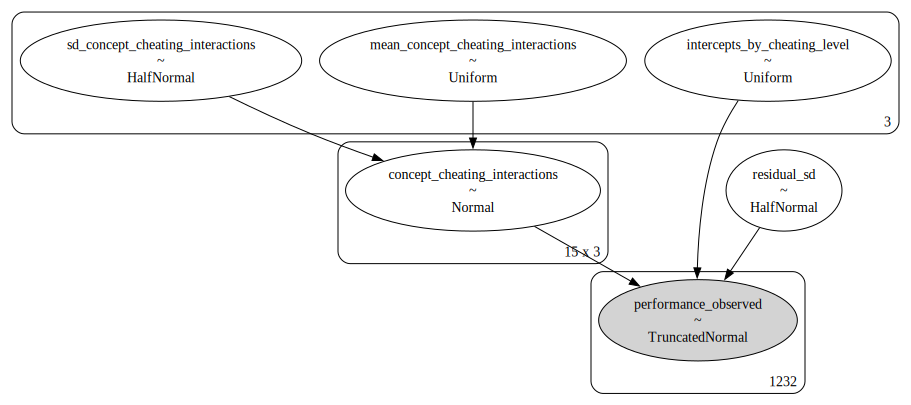

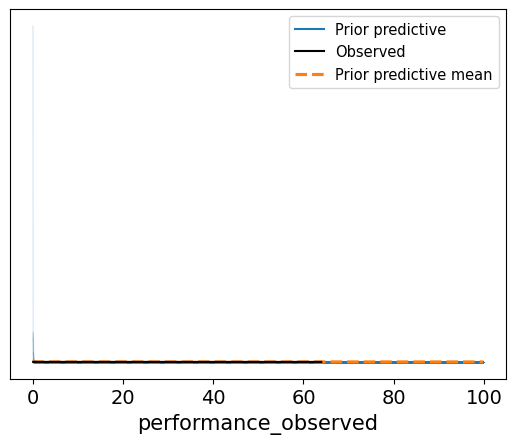

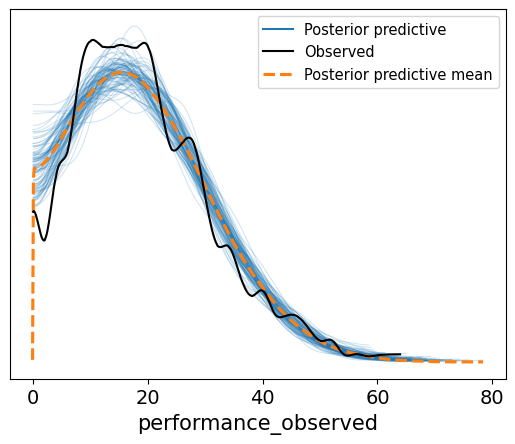

In [8]:
# =============================================================================
# 2. RQ2: PERFORMANCE MODEL
# =============================================================================
print("Fitting RQ2: Performance Model...")
performance_model = build_model(df, concepts, outcome_col='performance', lower=0, upper=100)
trace_performance = sample_model(performance_model)
print("Done.")

with performance_model:
    ppc_performance_prior = pm.sample_prior_predictive(model=performance_model)
    ppc_performance_posterior = pm.sample_posterior_predictive(trace_performance, random_seed=42)

az.plot_ppc(ppc_performance_prior, group='prior', observed=True)
az.plot_ppc(ppc_performance_posterior, num_pp_samples=100)
pm.model_to_graphviz(performance_model)

Fitting RQ3: Experience Model...


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercepts_by_cheating_level, mean_concept_cheating_interactions, sd_concept_cheating_interactions, concept_cheating_interactions, residual_sd]


Output()

Sampling 4 chains for 300 tune and 500 draw iterations (1_200 + 2_000 draws total) took 58 seconds.
There were 1318 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Sampling: [concept_cheating_interactions, experience_observed, intercepts_by_cheating_level, mean_concept_cheating_interactions, residual_sd, sd_concept_cheating_interactions]


Done.


Sampling: [experience_observed]


Output()

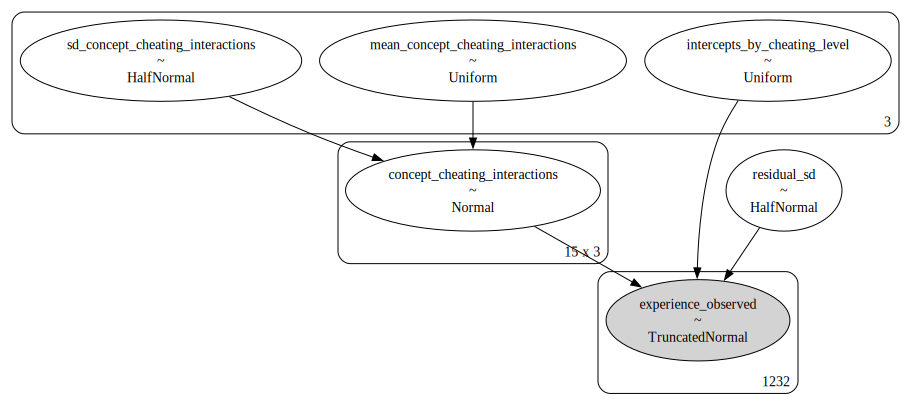

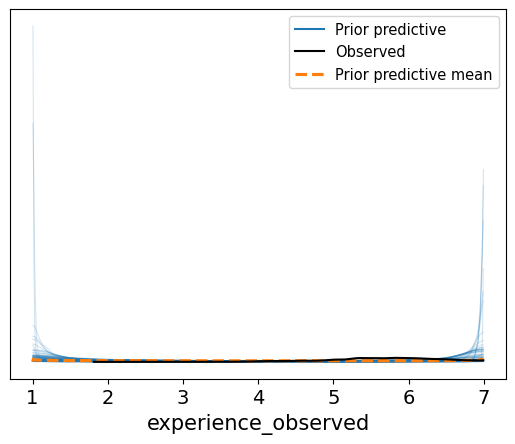

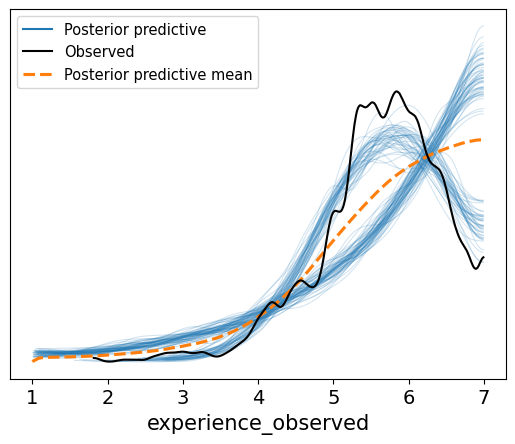

In [9]:
# =============================================================================
# 3. RQ3: EXPERIENCE MODEL
# =============================================================================
print("Fitting RQ3: Experience Model...")
experience_model = build_model(df, concepts, outcome_col='experience', lower=1, upper=7)
trace_experience = sample_model(experience_model)
print("Done.")

with experience_model:
    ppc_experience_prior = pm.sample_prior_predictive(model=experience_model)
    ppc_experience_posterior = pm.sample_posterior_predictive(trace_experience, random_seed=42)

az.plot_ppc(ppc_experience_prior, group='prior', observed=True)
az.plot_ppc(ppc_experience_posterior, num_pp_samples=100)
pm.model_to_graphviz(experience_model)

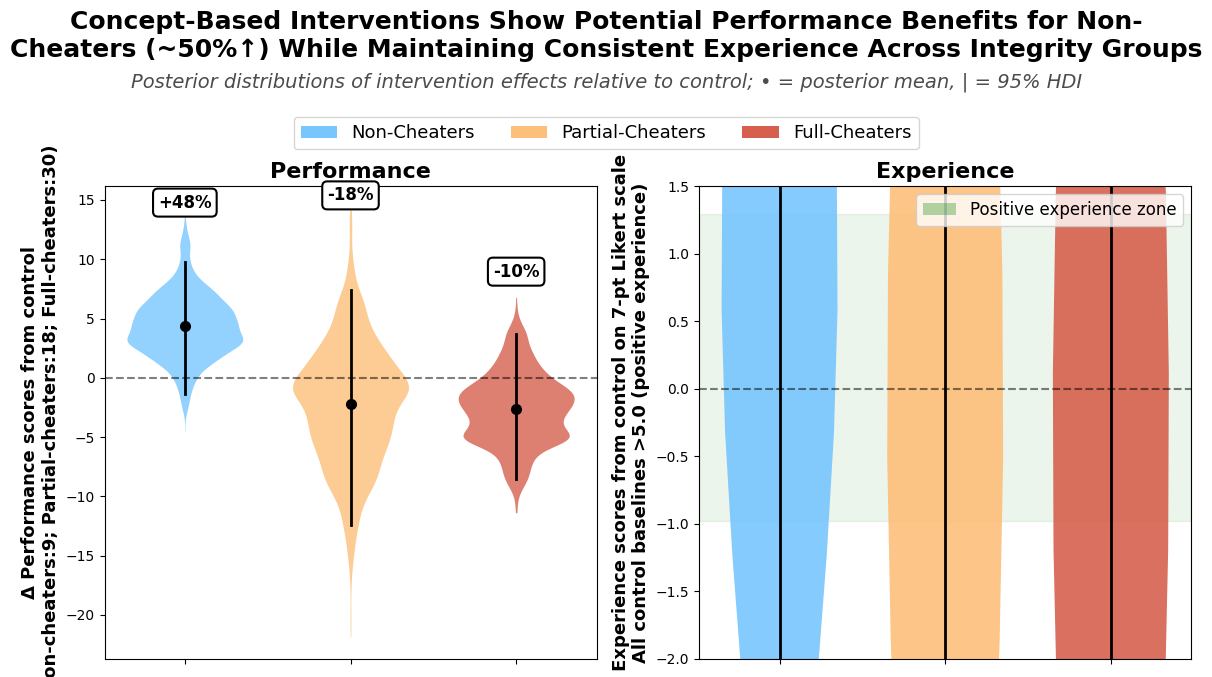

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
import arviz as az

def create_combined_impact_violin(trace_perf, trace_exp, concepts):
    """Violin plot showing performance and experience effects with clear legends"""
    
    # === Settings ===
    colors = {'Non-Cheaters': '#78c6fe', 'Partial-Cheaters': '#fdbf7a', 'Full-Cheaters': '#d6604d'}
    groups = ['Non-Cheaters', 'Partial-Cheaters', 'Full-Cheaters']
    
    perf_improvements = {'Non-Cheaters': '+48%', 'Partial-Cheaters': '-18%', 'Full-Cheaters': '-10%'}
    
    # === Extract effect sizes function ===
    def extract_effects(trace, outcome):
        intercepts = trace.posterior['intercepts_by_cheating_level'].values.reshape(-1, 3)
        interactions = trace.posterior['concept_cheating_interactions'].values.reshape(-1, len(concepts), 3)
        rows = []
        for i, group in enumerate(groups):
            concept_effects = [(intercepts[:, i] + interactions[:, j, i]) - intercepts[:, i] for j in range(len(concepts))]
            for e in np.mean(concept_effects, axis=0):
                rows.append({'outcome': outcome, 'group': group, 'effect': e})
        return rows
    
    df_violin = pd.DataFrame(
        extract_effects(trace_perf, 'Performance') +
        extract_effects(trace_exp, 'Experience')
    )
    
    fig, axes = plt.subplots(1, 2, figsize=(12, 7), sharey=False)
    
    # === Performance plot ===
    ax_perf = axes[0]
    data_perf = df_violin[df_violin['outcome'] == 'Performance']
    
    for i, group in enumerate(groups):
        subset = data_perf[data_perf['group'] == group]['effect'].values
        parts = ax_perf.violinplot([subset], positions=[i], widths=0.7,
                                   showmeans=False, showextrema=False)
        for pc in parts['bodies']:
            pc.set_facecolor(colors[group])
            pc.set_alpha(0.8)
            pc.set_edgecolor('black')
            pc.set_linewidth(0)
        
        mean_val = np.mean(subset)
        hdi_low, hdi_high = az.hdi(subset, hdi_prob=0.95)
        ax_perf.plot(i, mean_val, 'o', color='black', markersize=7, zorder=3)
        ax_perf.plot([i, i], [hdi_low, hdi_high], 'k-', linewidth=2, zorder=2)
        
        # Percentage improvement annotation
        y_pos = max(subset) + (ax_perf.get_ylim()[1] - max(subset)) * 0.15
        ax_perf.text(i, y_pos, perf_improvements[group], 
                     ha='center', va='bottom', fontsize=12, fontweight='bold',
                     color='black', bbox=dict(boxstyle='round,pad=0.3', 
                     facecolor='white', edgecolor='black', linewidth=1.5))
    
    ax_perf.axhline(0, color='black', linestyle='--', linewidth=1.5, alpha=0.5)
    ax_perf.set_title('Performance', fontsize=16, fontweight='bold')
    ax_perf.set_xticks(range(len(groups)))
    ax_perf.set_xticklabels([])
    ax_perf.set_ylabel("Δ Performance scores from control\n(Non-cheaters:9; Partial-cheaters:18; Full-cheaters:30)", fontsize=13, fontweight='bold')
    ax_perf.grid(True, alpha=0.3, axis='y')
    
    # === Experience plot ===
    ax_exp = axes[1]
    data_exp = df_violin[df_violin['outcome'] == 'Experience']
    
    # Positive experience zone shading
    control_baselines = [5.71, 5.98, 5.74]
    min_thresh = min([5.0 - b for b in control_baselines])
    max_thresh = max([7.0 - b for b in control_baselines])
    ax_exp.axhspan(min_thresh, max_thresh, alpha=0.08, color='green', label='Positive experience zone')
    ax_exp.axhline(0, color='black', linestyle='--', linewidth=1.5, alpha=0.5, label='No change from control')

    for i, group in enumerate(groups):
        subset = data_exp[data_exp['group'] == group]['effect'].values
        parts = ax_exp.violinplot([subset], positions=[i], widths=0.7,
                                  showmeans=False, showextrema=False)
        for pc in parts['bodies']:
            pc.set_facecolor(colors[group])
            pc.set_alpha(0.9)
            pc.set_edgecolor('black')
            pc.set_linewidth(0)
        
        mean_val = np.mean(subset)
        hdi_low, hdi_high = az.hdi(subset, hdi_prob=0.95)
        ax_exp.plot(i, mean_val, 'o', color='black', markersize=7, zorder=3)
        ax_exp.plot([i, i], [hdi_low, hdi_high], 'k-', linewidth=2, zorder=2)
    
    ax_exp.set_title('Experience', fontsize=16, fontweight='bold')
    ax_exp.set_ylim(-2, 1.5)
    ax_exp.set_xticks(range(len(groups)))
    ax_exp.set_xticklabels([])
    ax_exp.set_ylabel("Δ Experience scores from control on 7-pt Likert scale\nAll control baselines >5.0 (positive experience)", fontsize=13, fontweight='bold')
    ax_exp.grid(True, alpha=0.3, axis='y')
    
    # === Axis-level legend for Experience subplot only ===
    exp_handles = [
        mpatches.Patch(facecolor='green', alpha=0.3, label='Positive experience zone'),
        # Line2D([0], [0], color='black', linestyle='--', linewidth=1.5, alpha=0.5, label='No change from control')
    ]
    ax_exp.legend(handles=exp_handles, loc='upper right', fontsize=12, frameon=True, fancybox=True)
    
    # === Common group legend below title ===
    group_legend_elements = [
        mpatches.Patch(facecolor=colors[group], label=group) for group in groups
    ]
    fig.suptitle(
        'Concept-Based Interventions Show Potential Performance Benefits for Non-\nCheaters (~50%↑) While Maintaining Consistent Experience Across Integrity Groups',
        fontsize=18, fontweight='bold', y=0.98
    )
    fig.legend(
        handles=group_legend_elements,
        loc='upper center',
        bbox_to_anchor=(0.5, 0.84),
        ncol=3,
        fontsize=13,
        frameon=True,
        fancybox=True
    )
    ax_perf.grid(False)
    ax_exp.grid(False)
    
    plt.figtext(
        0.5, 0.87,
        'Posterior distributions of intervention effects relative to control; • = posterior mean, | = 95% HDI',
        ha='center', fontsize=14, style='italic', color='black', alpha=0.7
    )
    
    plt.tight_layout(rect=[0, 0.02, 1, 0.88])
    plt.show()


create_combined_impact_violin(trace_performance, trace_experience, concepts)

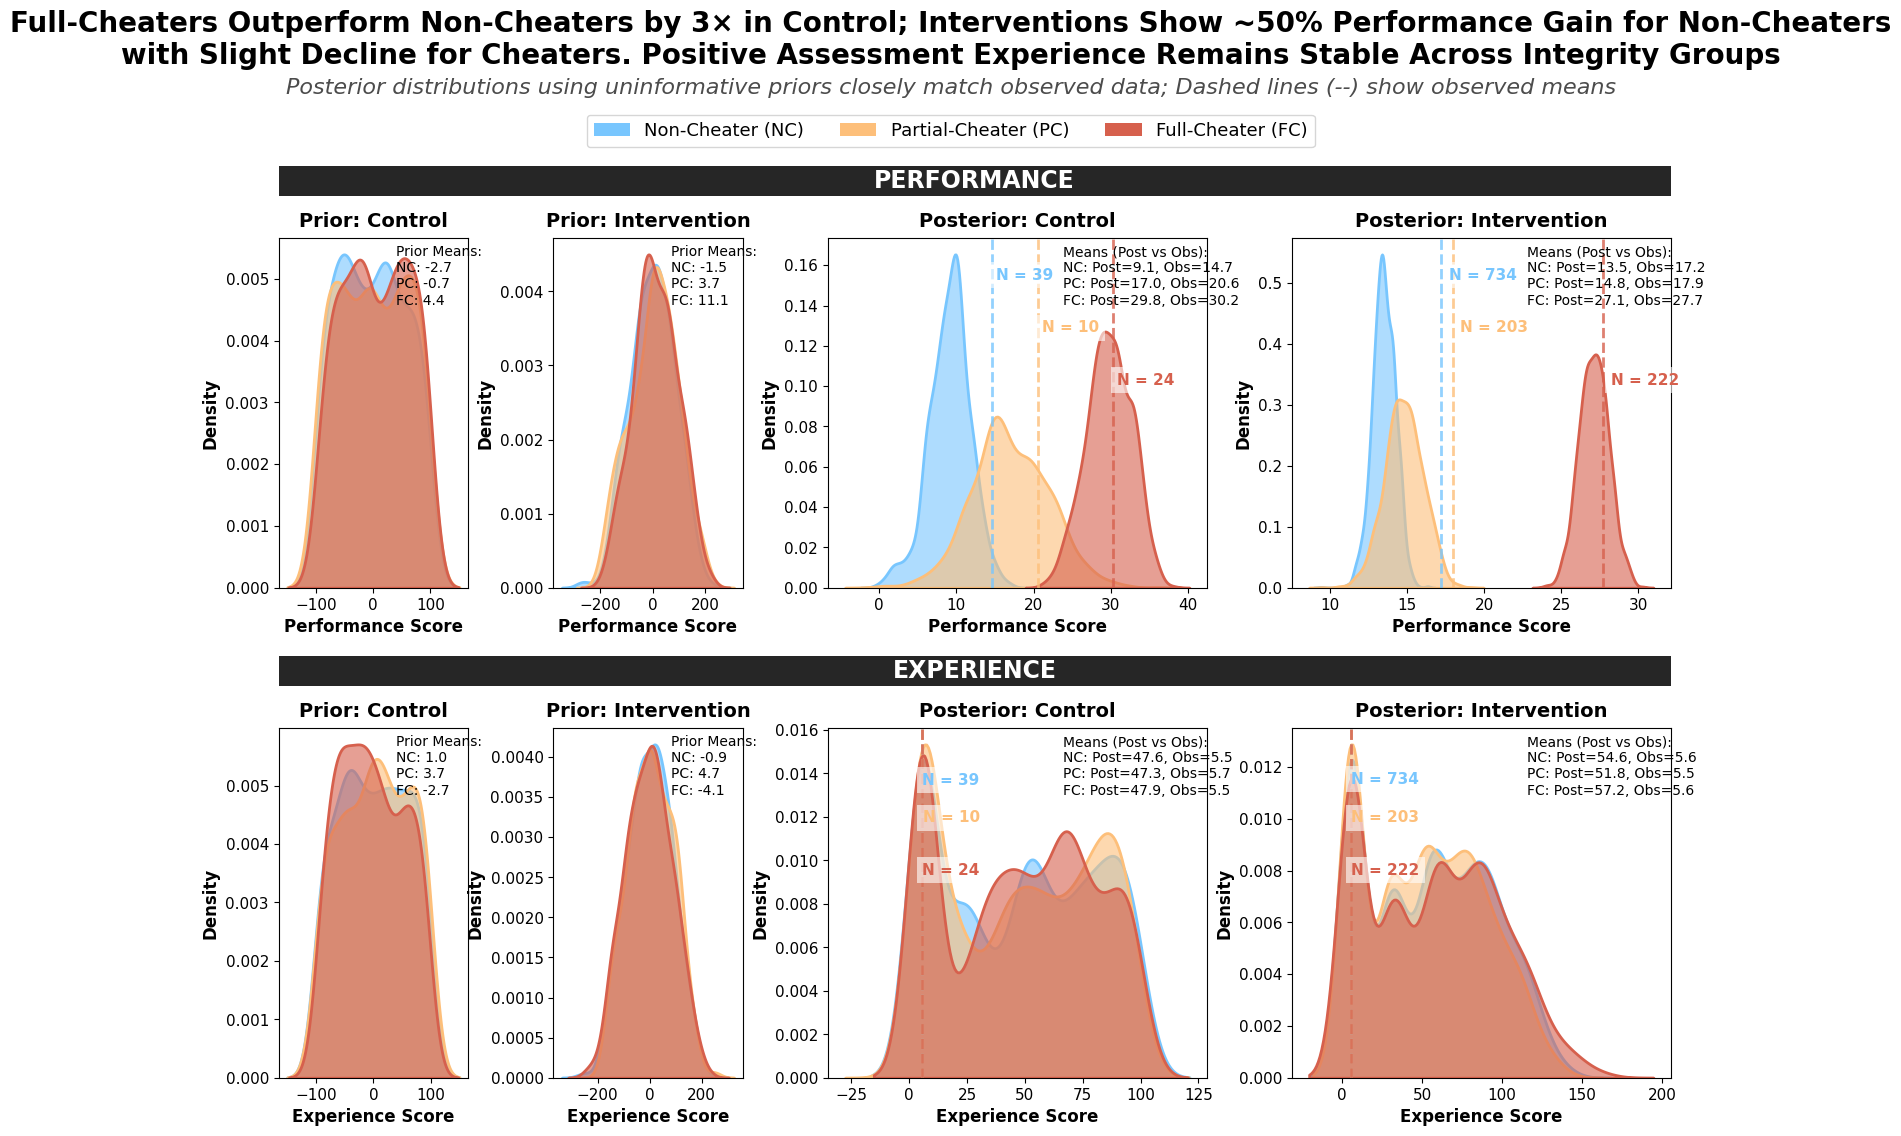

In [6]:
# =============================================================================
# 6. COMBINED PERFORMANCE & EXPERIENCE VALIDATION PLOT FUNCTION
# =============================================================================
def plot_combined_validation(trace_perf, trace_exp, ppc_perf_prior, ppc_exp_prior, df, concepts):
    """Combined validation plot matching RQ1 styling"""
    
    categories = ['Non-Cheater (NC)', 'Partial-Cheater (PC)', 'Full-Cheater (FC)']
    short_cats = ['NC', 'PC', 'FC']
    colors = ['#78c6fe', '#fdbf7a', '#d6604d']
    
    outcomes = {
        'Performance': {'trace': trace_perf, 'ppc_prior': ppc_perf_prior, 'col_name': 'performance'},
        'Experience': {'trace': trace_exp, 'ppc_prior': ppc_exp_prior, 'col_name': 'experience'}
    }
    
    fig = plt.figure(figsize=(16, 12))
    
    # Create gridspec with proper spacing: title area, legend area, plots
    gs_main = fig.add_gridspec(2, 4, width_ratios=[1,1,2,2], 
                               hspace=0.4, wspace=0.3, 
                               top=0.78, bottom=0.08, left=0.08, right=0.95)
    
    for outcome_idx, (outcome_name, cfg) in enumerate(outcomes.items()):
        # Header bar for each outcome
        header_ax = fig.add_subplot(gs_main[outcome_idx, :])
        header_y_position = header_ax.get_position().y1 + 0.035
        header_ax.set_position([header_ax.get_position().x0, header_y_position,
                                header_ax.get_position().width, 0.025])
        header_ax.add_patch(plt.Rectangle((0,0),1,1, facecolor='black', alpha=0.85, 
                                         transform=header_ax.transAxes))
        header_ax.text(0.5, 0.5, outcome_name.upper(), ha='center', va='center', 
                      fontsize=17, fontweight='bold', color='white', 
                      transform=header_ax.transAxes)
        header_ax.axis('off')

        # Extract samples
        intercepts = cfg['trace'].posterior['intercepts_by_cheating_level'].values.reshape(-1,3)
        interactions = cfg['trace'].posterior['concept_cheating_interactions'].values.reshape(-1,len(concepts),3)
        prior_intercepts = cfg['ppc_prior'].prior['intercepts_by_cheating_level'].values.reshape(-1,3)
        prior_interactions = cfg['ppc_prior'].prior['concept_cheating_interactions'].values.reshape(-1,len(concepts),3)

        post_control = intercepts
        post_intervention = intercepts + interactions.mean(axis=1)
        prior_control = prior_intercepts
        prior_intervention = prior_intercepts + prior_interactions.mean(axis=1)

        control_obs = df[df['concept']=='control'].groupby('cheating_behavior')[cfg['col_name']].mean()
        intervention_obs = df[df['concept']!='control'].groupby('cheating_behavior')[cfg['col_name']].mean()

        configs = [
            {'data': prior_control, 'obs': control_obs, 'title':'Prior: Control', 
             'col':0, 'is_prior':True, 'is_control':True},
            {'data': prior_intervention, 'obs': intervention_obs, 'title':'Prior: Intervention', 
             'col':1, 'is_prior':True, 'is_control':False},
            {'data': post_control, 'obs': control_obs, 'title':'Posterior: Control', 
             'col':2, 'is_prior':False, 'is_control':True},
            {'data': post_intervention, 'obs': intervention_obs, 'title':'Posterior: Intervention', 
             'col':3, 'is_prior':False, 'is_control':False}
        ]

        for cfg_plot in configs:
            ax = fig.add_subplot(gs_main[outcome_idx, cfg_plot['col']])
            group_data = df[df['concept']=='control'] if cfg_plot['is_control'] else df[df['concept']!='control']
            group_counts = group_data['cheating_behavior'].value_counts().sort_index()
            plot_means, obs_means = [], []

            for i, (cat, sc, color) in enumerate(zip(categories, short_cats, colors)):
                sns.kdeplot(cfg_plot['data'][:,i], ax=ax, color=color, fill=True, 
                           alpha=0.6, linewidth=2)
                plot_mean = cfg_plot['data'][:,i].mean()
                plot_means.append(plot_mean)

                if not cfg_plot['is_prior'] and i in cfg_plot['obs'].index:
                    obs_mean = cfg_plot['obs'].iloc[i]
                    obs_means.append(obs_mean)
                    ax.axvline(obs_mean, color=color, linestyle='--', linewidth=2, alpha=0.8)
                    
                    # N labels
                    offset = 0.5 if outcome_name=='Performance' else 0.1
                    ax.text(obs_mean + offset, ax.get_ylim()[1]*(0.88 - i*0.15), 
                           f"N = {group_counts.get(i,0)}", fontsize=11, fontweight='bold', 
                           color=color, bbox=dict(facecolor='white', alpha=0.6, edgecolor='none'))

            ax.set_title(cfg_plot['title'], fontweight='bold', fontsize=14, pad=8)
            ax.set_xlabel(f'{outcome_name} Score', fontsize=12, fontweight='bold')
            ax.set_ylabel('Density', fontsize=12, fontweight='bold')
            ax.tick_params(axis='both', labelsize=11)
            ax.grid(False)

            # Stats text box
            if cfg_plot['is_prior']:
                stats_text = '\n'.join([f'{sc}: {mean:.1f}' 
                                       for sc, mean in zip(short_cats, plot_means)])
                header = 'Prior Means:\n'
            else:
                stats_text = '\n'.join([f'{sc}: Post={post:.1f}, Obs={obs:.1f}' 
                                       for sc, post, obs in zip(short_cats, plot_means, obs_means)])
                header = 'Means (Post vs Obs):\n'
            
            ax.text(0.62, 0.98, f'{header}{stats_text}', transform=ax.transAxes, 
                   va='top', fontsize=10)

    # Main title (top)
    plt.suptitle('Full-Cheaters Outperform Non-Cheaters by 3× in Control; Interventions Show ~50% Performance Gain for Non-Cheaters\nwith Slight Decline for Cheaters. Positive Assessment Experience Remains Stable Across Integrity Groups',
                fontsize=20, fontweight='bold', y=0.97)
    
    # Subtitle (below title)
    plt.figtext(0.5, 0.9, 
               'Posterior distributions using uninformative priors closely match observed data; '
               'Dashed lines (--) show observed means',
               ha='center', fontsize=16, style='italic', color='black', alpha=0.7)

    # Legend (below subtitle, above plots)
    legend_elements = [mpatches.Patch(facecolor=color, label=cat) 
                      for cat, color in zip(categories, colors)]
    fig.legend(handles=legend_elements, loc='upper center', bbox_to_anchor=(0.5, 0.89), 
              ncol=3, fontsize=13, frameon=True, fancybox=True)

    plt.tight_layout(rect=[0, 0.02, 1, 0.82])
    plt.show()

plot_combined_validation(trace_perf=trace_performance, trace_exp=trace_experience,
                        ppc_perf_prior=ppc_performance_prior, ppc_exp_prior=ppc_experience_prior,
                        df=df, concepts=concepts)